# Reupload-Encoding Variational Classifier

In [1]:
from visualizer import *
import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform=transforms.Compose([
            transforms.Resize(size=18),
            transforms.CenterCrop(size=16),
            transforms.ToTensor()
        ])

In [3]:
train = datasets.ImageFolder(root='./dataset/dataset_train', transform=transform)
test = datasets.ImageFolder(root='./dataset/dataset_test', transform=transform)
rng = np.random.default_rng(seed=123401234)
num_classes = 4

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

train_set_img = torch.squeeze(train_set_img[:,0,:,:])
test_set_img = torch.squeeze(test_set_img[:,0,:,:])


# permute the arrays so we can visualize different classes with first 10 imgs
rand_idx_train = rng.permutation(len(train_set_img))
X_train = train_set_img[rand_idx_train]
Y_train = train_set_labels[rand_idx_train]

rand_idx_test = rng.permutation(len(test_set_img))
X_test = test_set_img[rand_idx_test]
Y_test = test_set_labels[rand_idx_test]


In [ ]:
"""
train = datasets.MNIST('./dataset', train=True, download=True,
                       transform=transform)
test = datasets.MNIST('./dataset', train=False,
                       transform=transform)

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

X_train = train_set_img
X_test = test_set_img
Y_train = train_set_labels
Y_test = test_set_labels
"""

Input shapes: X_train_input: torch.Size([1000, 256]), X_test_input: torch.Size([200, 256]),Y_train_input: torch.Size([1000]), Y_test_input: torch.Size([200])
number of samples with label 0 in train set: 250
number of samples with label 1 in train set: 250
number of samples with label 2 in train set: 250
number of samples with label 3 in train set: 250
number of samples with label 0 in test set: 50
number of samples with label 1 in test set: 50
number of samples with label 2 in test set: 50
number of samples with label 3 in test set: 50
first 10 img of train set:


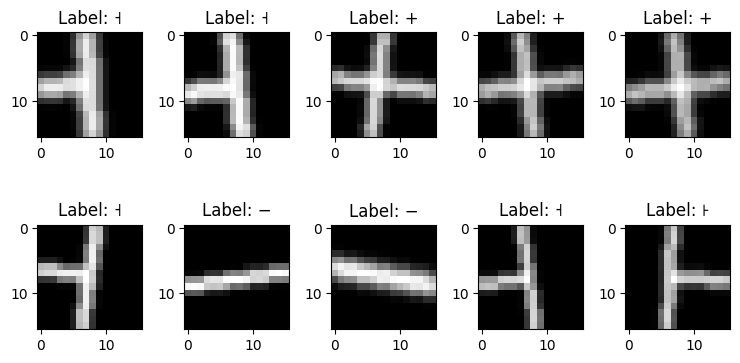

In [9]:
### Visualize some img

classes = [0,1,2,3]
num_classes = len(classes)

def count_occurrences(x,y, set):
    for label in range(len(classes)):
        occurrences = x[y == label].shape[0]
        print(f"number of samples with label {label} in {set} set: {occurrences}")

padding = 0
X_train_input = X_train
Y_train_input = Y_train
X_test_input = X_test
Y_test_input = Y_test

X_train_orig = np.copy(X_train_input.detach().numpy())
X_test_orig = np.copy(X_test_input.detach().numpy())

X_train_input = torch.reshape(X_train_input,(X_train_input.shape[0], -1))
X_test_input = torch.reshape(X_test_input,(X_test_input.shape[0], -1))
    
if padding > 0:
    print("WHY ARE U USING PADDING :(")

print(f"Input shapes: X_train_input: {X_train_input.shape}, X_test_input: {X_test_input.shape},"
            +f"Y_train_input: {Y_train_input.shape}, Y_test_input: {Y_test_input.shape}") 

count_occurrences(X_train_input,Y_train_input, "train")
count_occurrences(X_test_input,Y_test_input, "test")

print('first 10 img of train set:')
show_images(X_train_orig, Y_train_input)

#print('first 10 img of test set:')
#show_images(X_test_orig, Y_test_input)

# The model

In [5]:
#####################################
NUM_QUBITS = 8
NUM_LAYERS = 32             # 3 times reupload - 32*8*3 == 768 == 256*3
INPUT_DIM = 256
NUM_REUP = 3
#####################################

NUM_CLASSES = num_classes

In [6]:
class QVC(torch.nn.Module):
    def __init__(self, input_dim=INPUT_DIM, output_dim=NUM_CLASSES, num_qubits=NUM_QUBITS, 
                 num_layers=NUM_LAYERS, num_reup=NUM_REUP):
        super().__init__()
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.num_reup = num_reup
        # change device for higher performance!
        self.device = qml.device("default.qubit", wires=self.num_qubits)
        #print(self.device.capabilities())
        self.weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=self.num_layers, n_wires=self.num_qubits)

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(weights=weights*inputs+bias, wires=range(self.num_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]
            
        param_shapes = {"weights" : self.weights_shape,
                         "bias"   : self.weights_shape}
        init_vals = {"weights" : 0.01 * torch.rand(self.weights_shape),
                     "bias"    : 0.01 * torch.rand(self.weights_shape)}
        
        self.qcircuit = qml.qnn.TorchLayer(qnode=circuit, weight_shapes=param_shapes, init_method=init_vals)
        #drawer= qml.draw(circuit, show_all_wires=True, expansion_strategy="device")
        #dummy_vals = torch.zeros(self.weights_shape)
        #print(drawer(dummy_vals,dummy_vals,dummy_vals))

    def forward(self, x):
        inputs_stack = torch.hstack([x]*self.num_reup)
        return self.qcircuit(inputs_stack)


### Regularization (Lipschitz regularizer to enforce robustness & generalisation) + Optimization

Keep in mind that training takes its time when optimizing over the whole dataset!

In [7]:
#####################################
learning_rate = 0.001
REG = False
regularization_rate = 0.0
#####################################

feats_train = X_train_input#.to(device)
feats_test = X_test_input#.to(device)
labels_train = Y_train_input#.to(device)
labels_test = Y_test_input#.to(device)
num_train = feats_train.shape[0]

# see https://arxiv.org/abs/2311.11871
def lipschitz_regularizer(reg_param, weights):
    """for Pauli Rotation gates we have ||H_j|| = 0.5, thus (|w_j|)^2*(|H_j|)^2 = (|w_j|*|H_j|)^2"""
    return reg_param * torch.sum(torch.square(0.5*weights))

model = QVC()
#model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)
for name, param in model.named_parameters():
    print(name, param.size())
    print(f"requires_grad: {param.requires_grad}")

def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

QVC(
  (qcircuit): <Quantum Torch Layer: func=circuit>
)
qcircuit.weights torch.Size([32, 8, 3])
requires_grad: True
qcircuit.bias torch.Size([32, 8, 3])
requires_grad: True


In [8]:
# training loop and optimizer init

########################
PRETRAINED = True
load_epoch = 20    # 100
path = f'./model_checkpoints/QVC-ReUp-8-32-0_0-ep{load_epoch}'
########################

if PRETRAINED:
    epochs  = 0
    model.load_state_dict(torch.load(path))
    print(f'Loading state_dict of model for epoch {load_epoch} and eval on dataset, pls stand by..')
else:
    print(f'Beginning training loop for classes {classes}, {NUM_CLASSES} output qubits, {NUM_LAYERS} layers ({regularization_rate} regularized) QVC')
    epochs = 20

batch_size = 50
num_batches = num_train//batch_size

def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind

def print_acc(epoch, save_checkpoints=False):
    with torch.no_grad():
        if not PRETRAINED and save_checkpoints:
            torch.save(model.state_dict(), f"./model_checkpoints/QVC-new-ReUp-8-32-0_0-ep{epoch}")
        predictions_train = [model(f) for f in feats_train[:100]]
        predictions_test = [model(f) for f in feats_test[:100]]
        cost_approx_train = criterion(torch.stack(predictions_train), labels_train[:100])
        cost_approx_test = criterion(torch.stack(predictions_test), labels_test[:100])
        if REG:
            reg_val = lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
            cost_approx_train += reg_val
            cost_approx_test += reg_val
        
        acc_approx_train = accuracy(labels_train[:100], predictions_train)
        acc_approx_test = accuracy(labels_test[:100], predictions_test)
        
        print("Epoch {:5d} | Approx Cost (train): {:0.7f} | Approx Cost (val): {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f}"
        "".format(epoch, cost_approx_train, cost_approx_test, acc_approx_train, acc_approx_test))
    return predictions_train, predictions_test

for ep in range(epochs):
    batch_ind = gen_batches(num_train, num_batches)
    _, _ = print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]
        
        outputs = [model(f) for f in feats_train_batch]
        loss = criterion(torch.stack(outputs),labels_train_batch)
        if REG:
            loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        loss.backward()
        optimizer.step()

pred_train_final, pred_test_final = print_acc(epochs)      

Loading state_dict of model for epoch 20 and eval on dataset, pls stand by..
Epoch     0 | Approx Cost (train): 0.8978896 | Approx Cost (val): 0.9197941 | Acc train: 0.9700000 | Acc val: 0.9700000


In [12]:
#### ADVERSARIAL ATTACKS ####

def FGSM(loss, eps, feats, labels, weights):
    delta = torch.zeros_like(feats, requires_grad=True)
    loss = criterion(model(feats + delta), labels)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10, randomize=False, positive=False):
    if randomize:
        delta = torch.rand_like(feats, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]
        loss = criterion(torch.stack(outputs),labels)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        if positive:
            delta.data = torch.where((delta+feats)<0,-feats,delta)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
perturbed_X_train = PGD(model, feats=feats_train[:100], labels=labels_train[:100], epsilon=0.1, alpha=0.01, 
                  num_iter=10, randomize=False, positive=False)

pred_check = [model(f) for f in feats_train[:100]]
print(f'Benign accuracy: {accuracy(labels_train[:100], pred_check)}')
pred_adv = [model(f) for f in perturbed_X_train[:100]+feats_train[:100]]
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_X_orig = torch.reshape(perturbed_X_train, (100,16,16)).detach().numpy() 
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=torch.stack(pred_adv[10:]).detach().numpy())

In [ ]:
# here we can also check transferability by loading perturbations from other models

path = './perturbations/perturbations-ReUp-no_reg-ep20-PGD0_1-100_samples.npy'
perturbed_X_orig = np.load(path)
perturbed_X_train = torch.reshape(torch.from_numpy(perturbed_X_orig).float(), (100,256))

pred_check = [model(f) for f in feats_train[:100]]
print(f'Benign accuracy: {accuracy(labels_train[:100], pred_check)}')

pred_adv = [model(f) for f in perturbed_X_train[:100]+feats_train[:100]]
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=np.stack(pred_adv)[10:])
